# Sandia model for oxygen penetration
This is the model described in https://doi.org/10.1016/0141-3910(82)90003-9
A. V. Cunliffe and A. Davis, Polym. Degrad. Stab. **4**, 17 (1982).

The model is described by the equation
\begin{equation}
    \frac{d^2y}{d\lambda^2}=\frac{Ay}{By+1}
\end{equation}
where $y\equiv\frac{C}{C_0}$, $\lambda\equiv\frac{x}{l}$, $A\equiv\frac{c_1l^2}{D}$, and $B\equiv c_2C_0$.

In [1]:
import numpy as np
from scipy.integrate import solve_bvp
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import mplhep as hep

In [2]:
hep.style.use(hep.style.CMS)

In [3]:
# Define these as global variables
A, B = 5000, 50


def func_rrate(y):
    y[y < 0] = 0
    return A * y / (B * y + 1)


def solver(x, y):
    y[0][y[0] < 0] = 0
    return np.vstack((y[1], A * y[0] / (B * y[0] + 1)))


def bc(ya, yb):
    return np.array([ya[0] - 1, yb[0] - 1])

In [4]:
# Set colormap
values = range(4)
cmap = plt.get_cmap("Set1")
cNorm = colors.Normalize(vmin=0, vmax=values[-1])
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cmap)
# to change default color cycle
plt.rcParams["axes.prop_cycle"] = plt.cycler(color=plt.cm.Dark2.colors)

Plot solution for normalized oxygen concentration $y$

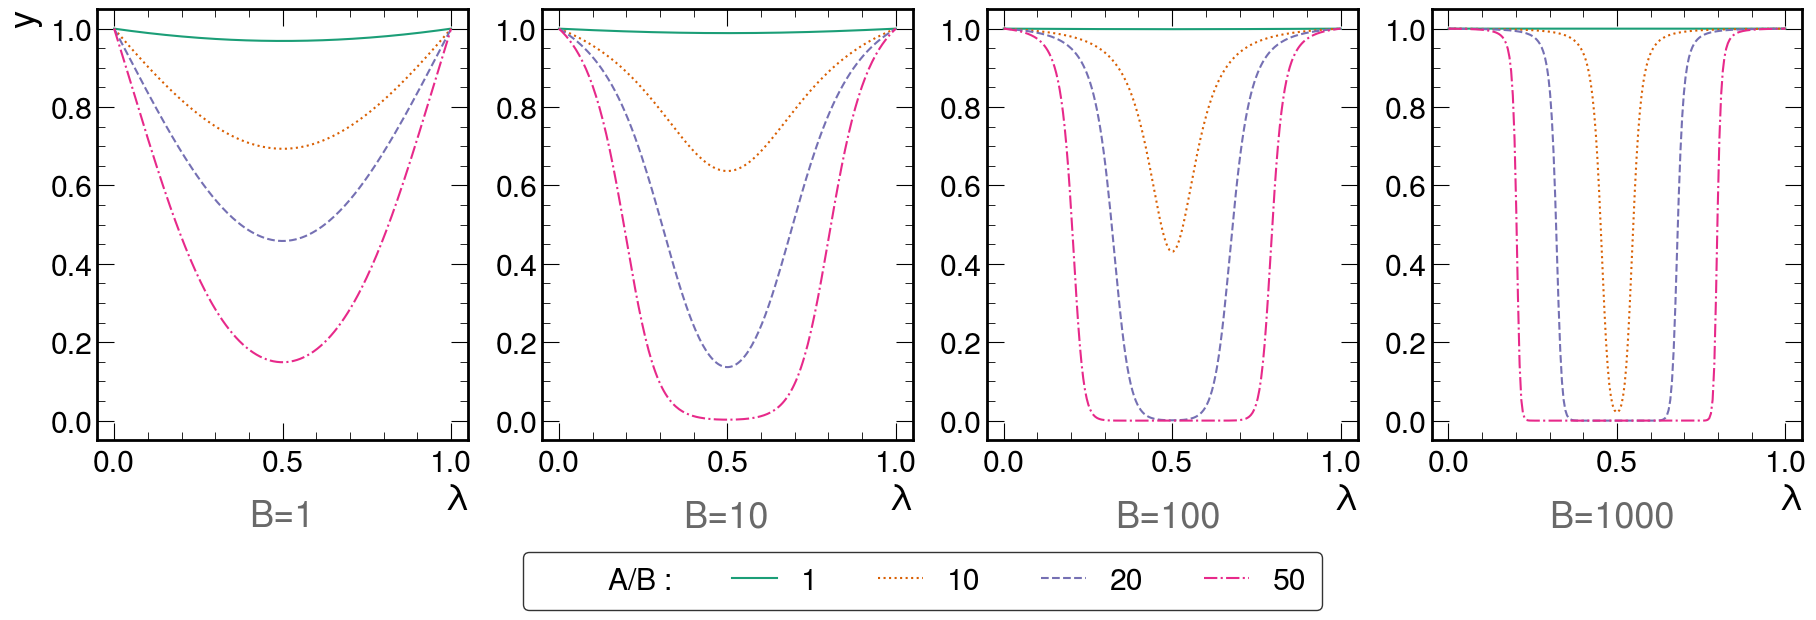

In [5]:
%matplotlib inline

# Scan values
beta = [1, 10, 100, 1000]
alpha = [
    # [1, 10, 20, 50],
    [1, 10, 20, 50],
    [10, 100, 200, 500],
    [100, 1000, 2000, 5000],
    [1000, 10000, 20000, 50000],
]
beta_x_label = [0.4, 0.37, 0.33, 0.3]
plots = [0, 0, 0, 0]
linestyles = ["solid", "dotted", "dashed", "dashdot"]

fig, ax = plt.subplots(1, 4, figsize=(22, 7))
for fi, b in enumerate(beta):
    for ix, a in enumerate(alpha[fi]):
        B = b
        A = a
        x = np.linspace(0, 1, 50)
        y_a = np.zeros((2, x.size))
        y_a[0] = 1
        y_a[1] = 0
        asol = solve_bvp(solver, bc, x, y_a)
        x_plot = np.linspace(0, 1, 200)
        y_plot_a = asol.sol(x_plot)[0]
        ydot_plot_a = asol.sol(x_plot)[1]
        rrate = func_rrate(y_plot_a)
        (plots[ix],) = ax[fi].plot(
            x_plot,
            rrate / rrate[0],
            label=f"A={A}",
            linestyle=linestyles[ix],
        )
    ax[fi].text(beta_x_label[fi], -0.27, f"B={B}", color="dimgrey")
    box = ax[fi].get_position()
    ax[fi].set_position(
        [
            box.x0,
            box.y0 + box.height * 0.2,
            box.width,
            box.height * 0.8,
        ]
    )
    ax[fi].set_xlim([-0.05, 1.05])
    ax[fi].set_ylim([-0.05, 1.05])
    ax[fi].set_xlabel(r"$\lambda$")

ax[0].set_ylabel(r"$y$")
ph = [plt.plot([], marker="", ls="")[0]]
leg = fig.legend(
    ph + plots,
    [r"$A/B$ :", "1", "10", "20", "50"],
    loc="lower center",
    bbox_to_anchor=(0.5, 0.0),
    ncols=5,
    frameon=True,
)
leg.get_frame().set_edgecolor("black")
fig.savefig(f"multifig_y.pdf")
plt.show()

In [7]:
import pde

In [8]:
class OxygenDiffusion(pde.PDEBase):
    """Model for oxygen diffusion"""

    def __init__(self, A=10.0, B=10.0, diffusivity=0.1):
        super().__init__()
        self.A = A
        self.B = B
        self.diffusivity = diffusivity
        self.bc = [{"value": 1}, {"value": 1}]

    def evolution_rate(self, state, t=0):
        s = state
        A = self.A
        B = self.B
        diff = self.diffusivity
        s.data[s.data < 0] = 0
        ds_dt = diff * s.laplace(self.bc) - A * s / (B * s + 1)
        return ds_dt

  0%|          | 0/20.0 [00:00<?, ?it/s]

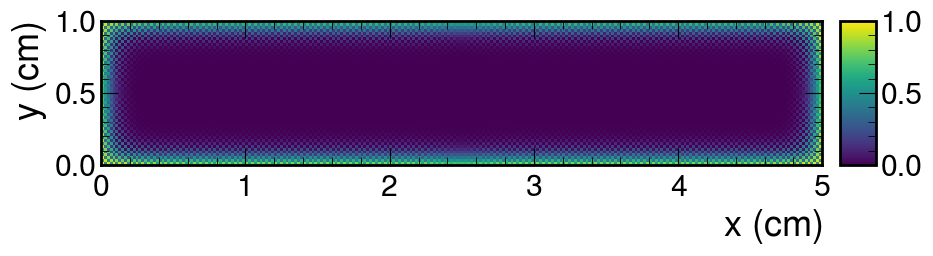

In [9]:
%matplotlib inline

A = 10
B = 10
diff = 0.01
fig_c, ax_c = plt.subplots(1, 1)
eq = OxygenDiffusion(A, B, diff)
grid = pde.CartesianGrid([[0, 5], [0, 1]], [250, 50], periodic=[False, False])
field = pde.ScalarField(grid, data=1)
sol = eq.solve(field, t_range=20, dt=1e-2)
sol.data[sol.data < 0] = 0
sol.data /= sol.data.max()
sol.plot(ax=ax_c)
ax_c.set_xlabel(r"$x$ (cm)")
ax_c.set_ylabel(r"$y$ (cm)")
plt.show()

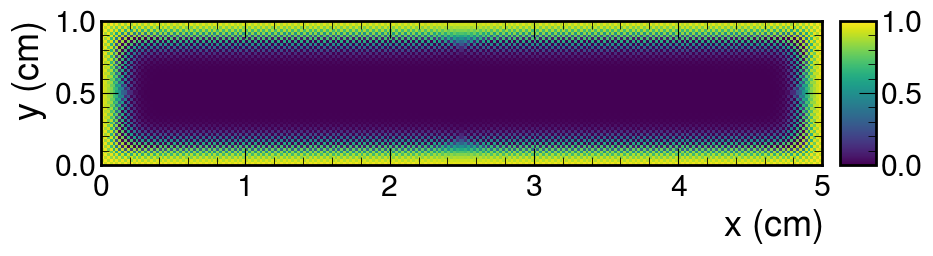

In [10]:
%matplotlib inline

fig_rr, ax_rr = plt.subplots(1, 1)
rr = (diff ** (-1)) * A * sol / (B * sol + 1)
rr.data /= rr.data.max()
rr.plot(ax=ax_rr)
ax_rr.set_xlabel(r"$x$ (cm)")
ax_rr.set_ylabel(r"$y$ (cm)")
# ax_rr.set_zlabel(r"$R/R_{0}$")
plt.show()

  0%|          | 0/10.0 [00:00<?, ?it/s]

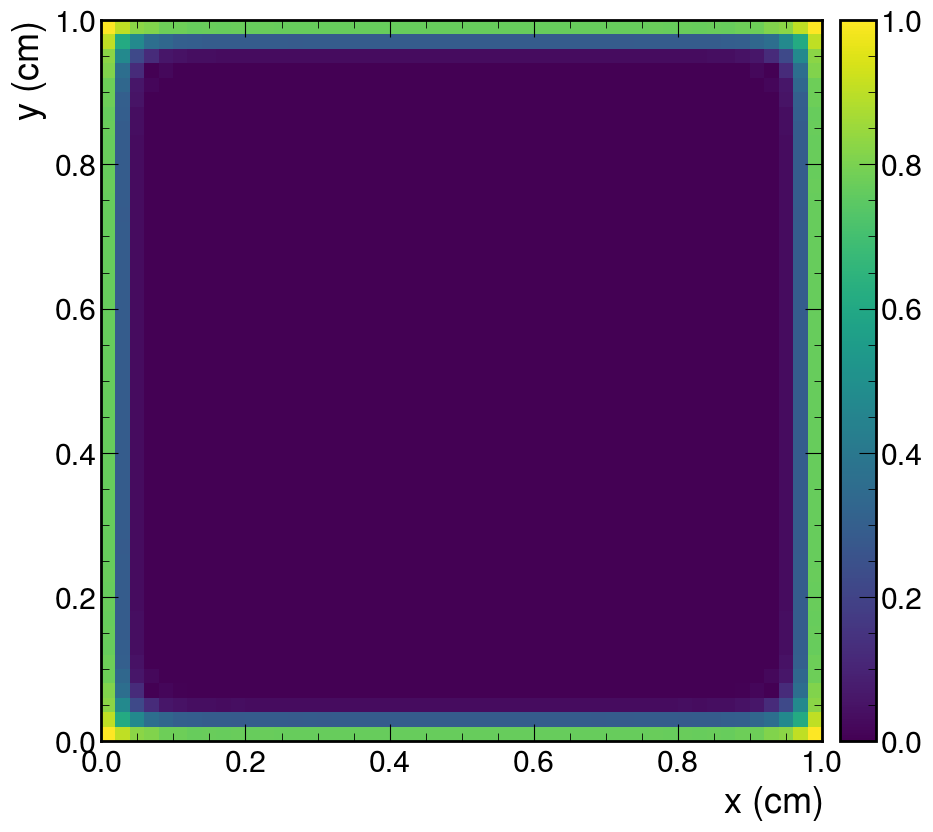

In [57]:
%matplotlib inline

A = 50000
B = 10000
diff = 0.01
fig_c, ax_c = plt.subplots(1, 1)
eq = OxygenDiffusion(A, B, diff)
grid = pde.CartesianGrid([[0, 1], [0, 1]], [50, 50], periodic=[False, False])
field = pde.ScalarField(grid, data=1)
sol = eq.solve(field, t_range=10, dt=1e-2)
sol.data[sol.data < 0] = 0
sol.data /= sol.data.max()
sol.plot(ax=ax_c)
ax_c.set_xlabel(r"$x$ (cm)")
ax_c.set_ylabel(r"$y$ (cm)")
plt.show()

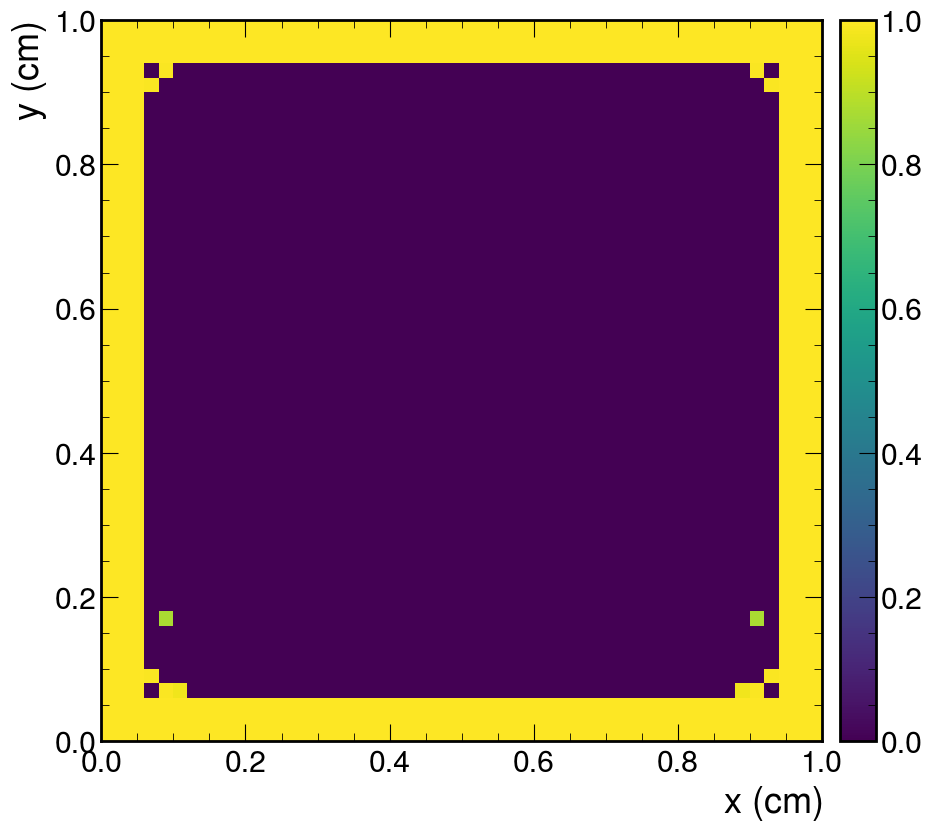

In [58]:
%matplotlib inline

fig_rr, ax_rr = plt.subplots(1, 1)
rr = (diff ** (-1)) * A * sol / (B * sol + 1)
rr.data /= rr.data.max()
rr.plot(ax=ax_rr)
ax_rr.set_xlabel(r"$x$ (cm)")
ax_rr.set_ylabel(r"$y$ (cm)")
# ax_rr.set_zlabel(r"$R/R_{0}$")
plt.show()